### Домашняя работа к уроку 5
### Студент: Абрамов А.В.

#### 1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, Flatten, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
tf.random.set_seed(1)

In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
airline_passengers_data = pd.read_csv('airline-passengers.csv')

In [5]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [6]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [7]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [8]:
data = airline_passengers_data.iloc[:, 1:]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
 1   year        144 non-null    int64
 2   mon         144 non-null    int64
dtypes: int64(3)
memory usage: 3.5 KB


In [10]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [11]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [12]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


In [13]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [14]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

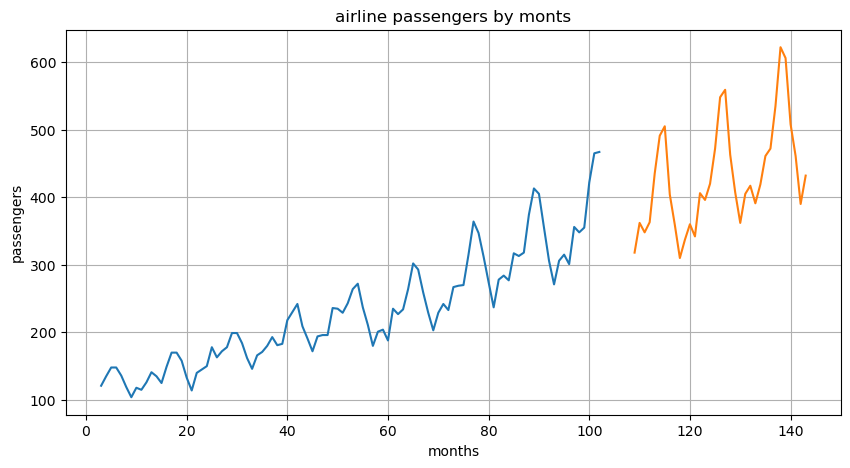

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [17]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [18]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [19]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [20]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11687 (45.65 KB)
Trainable params: 11687 (

In [21]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 1s 20ms/step - loss: 57278.6562 - mae: 226.5129 - val_loss: 195973.6562 - val_mae: 435.4138
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 56467.8281 - mae: 224.8065 - val_loss: 193092.7969 - val_mae: 432.1560
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 56044.1484 - mae: 224.3579 - val_loss: 189642.7344 - val_mae: 428.2433
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 55145.6992 - mae: 223.1038 - val_loss: 182560.4844 - val_mae: 420.1035
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 52716.0820 - mae: 219.3067 - val_loss: 165412.6719 - val_mae: 399.6275
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 46300.5391 - mae: 207.9768 - val_loss: 127582.6953 - val_mae: 349.9650
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 32449.2227 - mae: 176.8882 - val_loss: 65225.4258 - val_mae: 246.6553

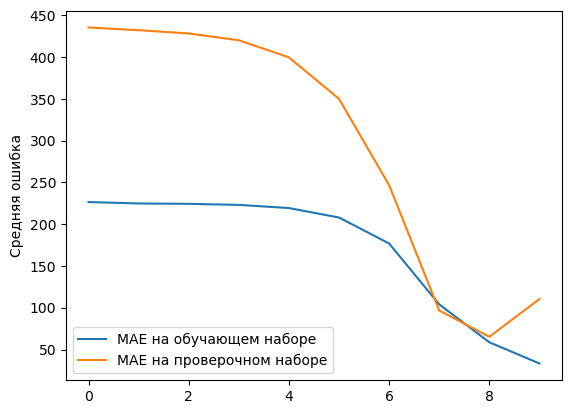

In [22]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [23]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [24]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 1099.7360 - mae: 25.1087 - val_loss: 12784.3936 - val_mae: 92.4032
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 1169.9116 - mae: 26.7340 - val_loss: 10250.5771 - val_mae: 79.8489
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 1116.6162 - mae: 26.4782 - val_loss: 11062.9883 - val_mae: 84.7822
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 1067.5834 - mae: 25.9389 - val_loss: 10754.7842 - val_mae: 83.5788
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 1039.7692 - mae: 25.4282 - val_loss: 10364.0156 - val_mae: 81.6750
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 999.1899 - mae: 24.9157 - val_loss: 10161.2686 - val_mae: 80.7692
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 971.1542 - mae: 24.5905 - val_loss: 9834.5010 - val_mae: 79.2329
Epoch 8/10
13/13 [============

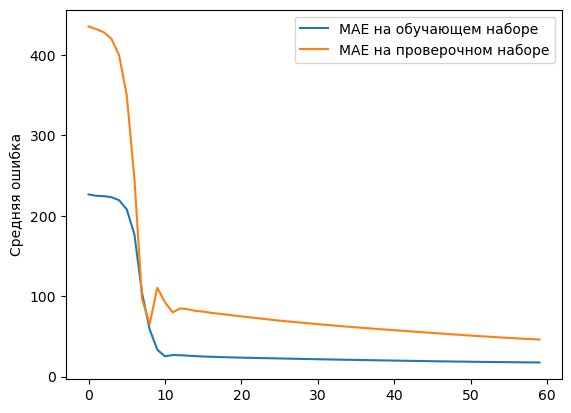

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 492.3827 - mae: 17.3770 - val_loss: 3911.3232 - val_mae: 45.5551
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 488.0299 - mae: 17.2859 - val_loss: 3858.2341 - val_mae: 45.0983
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 483.6642 - mae: 17.1940 - val_loss: 3806.8291 - val_mae: 44.6481
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 479.2511 - mae: 17.1012 - val_loss: 3756.8411 - val_mae: 44.2470
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 474.7578 - mae: 17.0085 - val_loss: 3708.0420 - val_mae: 43.8563
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 470.1495 - mae: 16.9133 - val_loss: 3660.1543 - val_mae: 43.4992
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 465.3922 - mae: 16.8202 - val_loss: 3612.9565 - val_mae: 43.1518
Epoch 8/10
13/13 [=======================

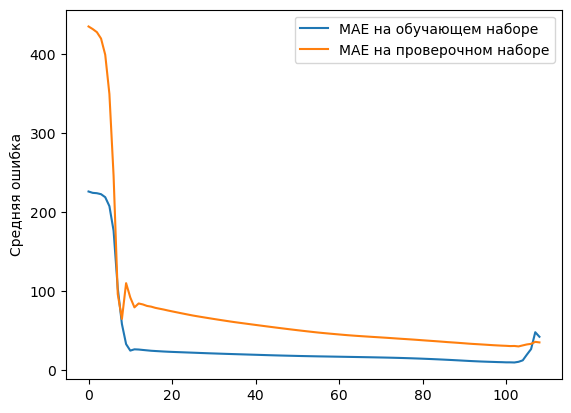

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 1324.2936 - mae: 30.1591 - val_loss: 1572.0997 - val_mae: 30.5236
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 291.1797 - mae: 12.8457 - val_loss: 2527.7461 - val_mae: 38.2342
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 282.7401 - mae: 14.1795 - val_loss: 1909.4297 - val_mae: 33.1974
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 198.3870 - mae: 11.5641 - val_loss: 1741.1897 - val_mae: 31.1213
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 200.9459 - mae: 11.2762 - val_loss: 1848.2174 - val_mae: 32.5971
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 165.5867 - mae: 10.2815 - val_loss: 1715.3597 - val_mae: 31.0556
Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 182.4379 - mae: 10.8715 - val_loss: 1700.8250 - val_mae: 31.2618
Epoch 2/10
13/13 [======================

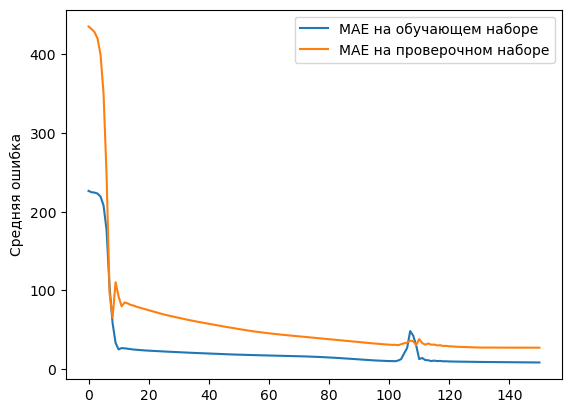

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 113.4689 - mae: 8.4506 - val_loss: 1162.2517 - val_mae: 27.3061
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 112.9268 - mae: 8.4255 - val_loss: 1158.6991 - val_mae: 27.2958
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 112.2861 - mae: 8.3906 - val_loss: 1156.1851 - val_mae: 27.2977
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 111.6548 - mae: 8.3703 - val_loss: 1152.8617 - val_mae: 27.2945
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 111.1643 - mae: 8.3355 - val_loss: 1149.9833 - val_mae: 27.2781
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 110.3991 - mae: 8.3098 - val_loss: 1147.6898 - val_mae: 27.2896
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 110.0034 - mae: 8.2828 - val_loss: 1143.8704 - val_mae: 27.2569
Epoch 8/10
13/13 [==============================

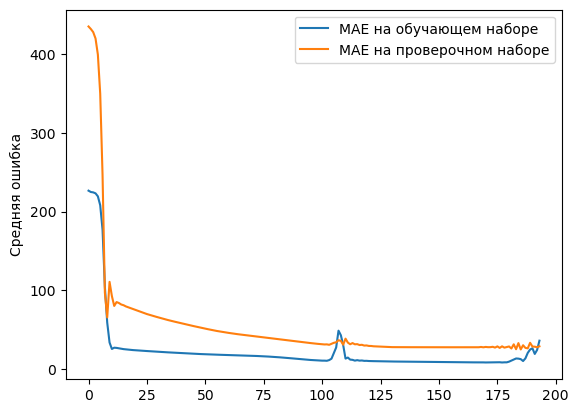

Epoch 1/10
13/13 [==============================] - 0s 5ms/step - loss: 1262.4500 - mae: 29.8100 - val_loss: 1288.2823 - val_mae: 28.0648
Epoch 2/10
13/13 [==============================] - 0s 5ms/step - loss: 696.3602 - mae: 22.9502 - val_loss: 1146.0398 - val_mae: 26.0955
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 360.0173 - mae: 15.8879 - val_loss: 1193.0865 - val_mae: 26.5212
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 636.5829 - mae: 22.8332 - val_loss: 1390.5776 - val_mae: 28.6648
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 602.7239 - mae: 20.3237 - val_loss: 1148.5793 - val_mae: 26.9818
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 244.0732 - mae: 13.2903 - val_loss: 1295.4785 - val_mae: 27.1920
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 143.2154 - mae: 9.7141 - val_loss: 1121.7212 - val_mae: 26.0515
Epoch 8/10
13/13 [=======================

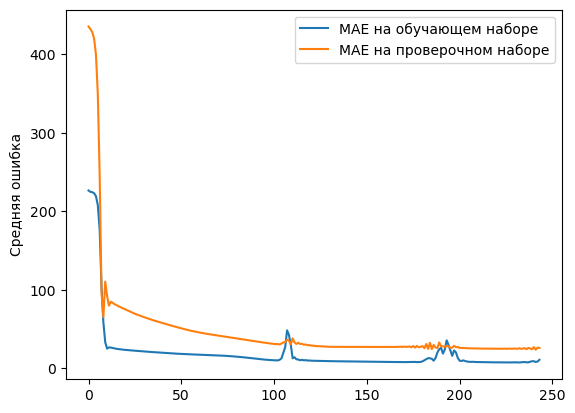

In [25]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [26]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 998us/step


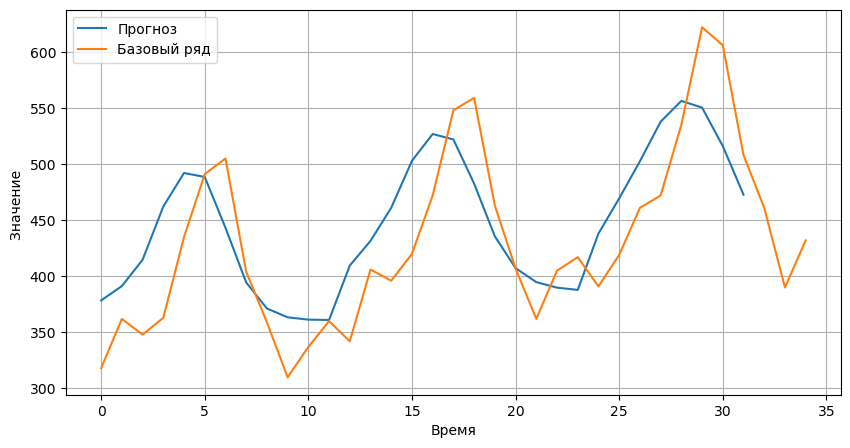

In [27]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

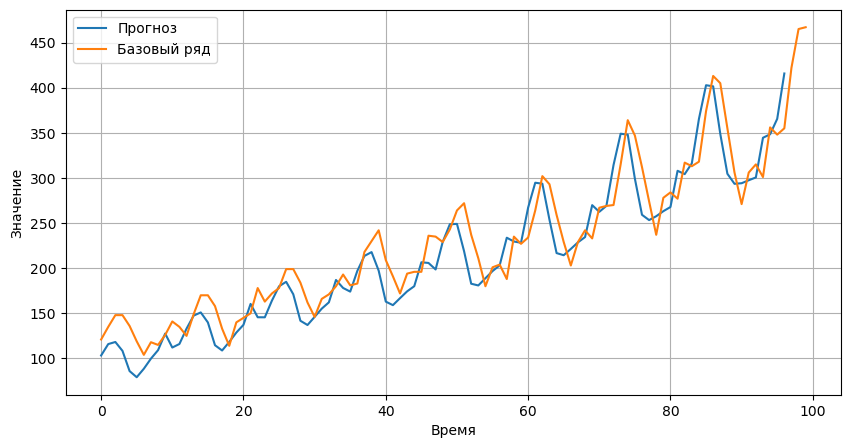

In [28]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [29]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 1ms/step - loss: 983.4463 - mae: 25.9946
train_loss: 289.6991271972656, train_m: 14.463346481323242
test_loss: 983.4462890625, test_m: 25.994565963745117


#### LSTM

In [32]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [33]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 4s 52ms/step - loss: 56648.1211 - mae: 225.6279 - val_loss: 193006.9219 - val_mae: 432.0099
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 56349.0508 - mae: 225.0039 - val_loss: 192045.9531 - val_mae: 430.9134
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 55413.7148 - mae: 223.1323 - val_loss: 188504.6406 - val_mae: 426.8636
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 52143.2109 - mae: 216.5320 - val_loss: 175450.5000 - val_mae: 411.6387
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 41579.7969 - mae: 193.7193 - val_loss: 132497.6719 - val_mae: 357.0412
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 16908.8066 - mae: 121.8939 - val_loss: 41184.7656 - val_mae: 193.5784
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 3426.5950 - mae: 44.3733 - val_loss: 5523.4575 - val_mae: 58.0733
Epoc

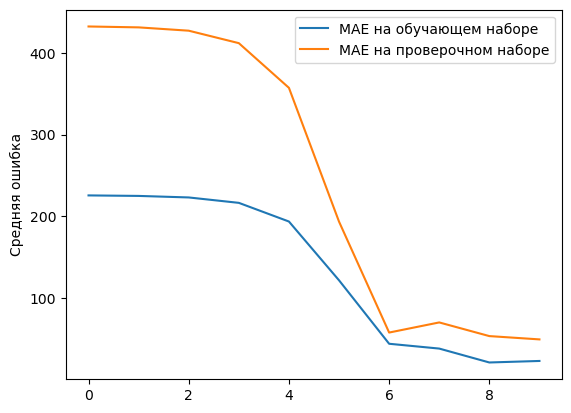

In [34]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [35]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [36]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 753.1866 - mae: 21.5407 - val_loss: 5079.9922 - val_mae: 51.9481
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 744.9977 - mae: 21.7322 - val_loss: 4671.4917 - val_mae: 49.8367
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 724.4703 - mae: 20.9377 - val_loss: 4808.8545 - val_mae: 50.7362
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 709.9851 - mae: 20.6556 - val_loss: 4670.1812 - val_mae: 49.9649
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 698.6661 - mae: 20.4058 - val_loss: 4571.5396 - val_mae: 49.4284
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 687.7120 - mae: 20.2195 - val_loss: 4474.1851 - val_mae: 48.9476
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 679.5484 - mae: 20.0815 - val_loss: 4375.7432 - val_mae: 48.4446
Epoch 8/10
13/13 [======================

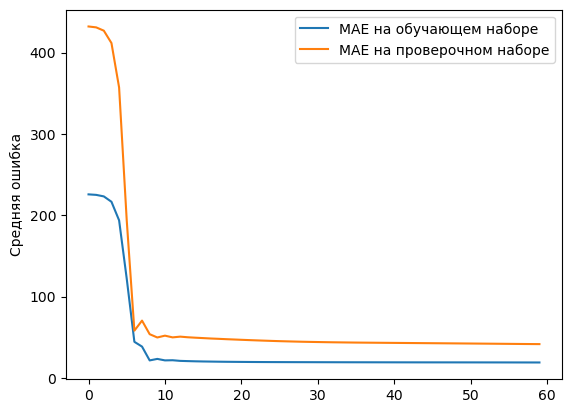

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 578.2705 - mae: 18.9612 - val_loss: 3031.6455 - val_mae: 41.4909
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 576.7885 - mae: 18.9447 - val_loss: 3014.9944 - val_mae: 41.4244
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 575.2611 - mae: 18.9268 - val_loss: 2998.2854 - val_mae: 41.3557
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 573.6849 - mae: 18.9075 - val_loss: 2981.5095 - val_mae: 41.2849
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 572.0555 - mae: 18.8868 - val_loss: 2964.6523 - val_mae: 41.2118
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 570.3678 - mae: 18.8645 - val_loss: 2947.7056 - val_mae: 41.1364
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 568.6170 - mae: 18.8406 - val_loss: 2930.6523 - val_mae: 41.0584
Epoch 8/10
13/13 [=======================

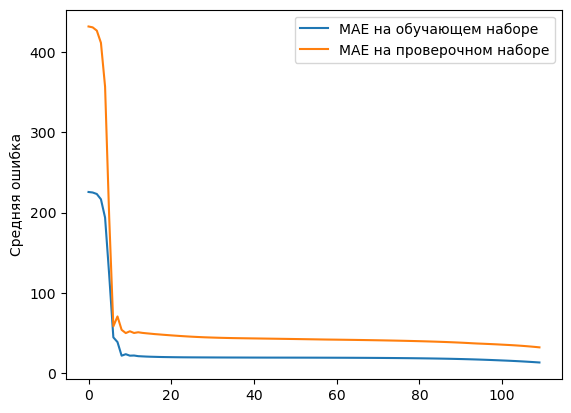

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 263.5329 - mae: 12.7194 - val_loss: 1484.5061 - val_mae: 31.3864
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 250.5018 - mae: 12.3784 - val_loss: 1426.2725 - val_mae: 30.8386
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 238.1363 - mae: 12.0574 - val_loss: 1369.8064 - val_mae: 30.2731
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 226.5557 - mae: 11.7589 - val_loss: 1315.6678 - val_mae: 29.6955
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 215.8535 - mae: 11.4878 - val_loss: 1264.3545 - val_mae: 29.1117
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 206.0903 - mae: 11.2171 - val_loss: 1216.2686 - val_mae: 28.5651
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 197.2955 - mae: 10.9551 - val_loss: 1171.7118 - val_mae: 28.0800
Epoch 8/10
13/13 [=======================

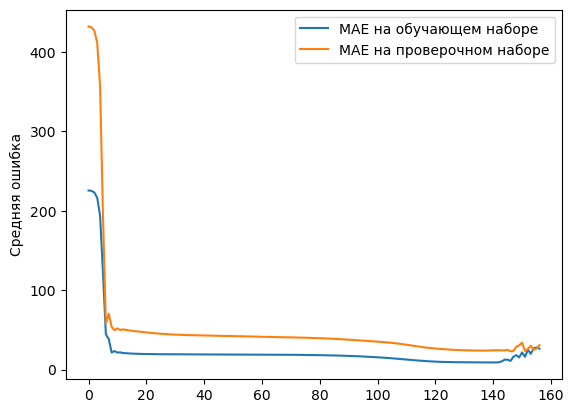

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 1183.1077 - mae: 30.9295 - val_loss: 1114.3127 - val_mae: 26.0003
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 554.5300 - mae: 20.8011 - val_loss: 1284.8749 - val_mae: 27.7606
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 503.5077 - mae: 18.8194 - val_loss: 1129.6316 - val_mae: 28.5135
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 507.9349 - mae: 19.7994 - val_loss: 1081.0115 - val_mae: 26.2176
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 263.1191 - mae: 13.5405 - val_loss: 1211.7542 - val_mae: 27.8611
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 165.9955 - mae: 9.9871 - val_loss: 870.6500 - val_mae: 24.4652
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 145.4843 - mae: 9.1670 - val_loss: 923.3549 - val_mae: 25.2791
Epoch 8/10
13/13 [==========================

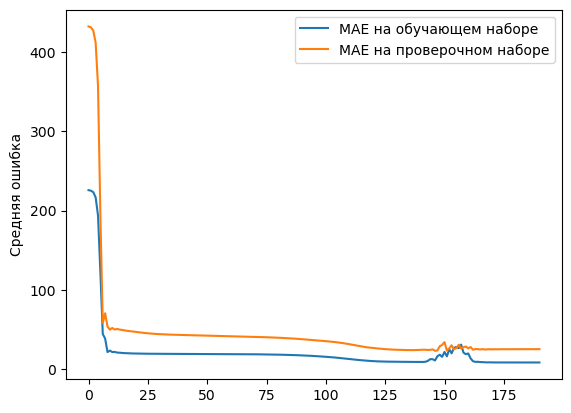

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 120.3662 - mae: 8.4027 - val_loss: 911.4402 - val_mae: 25.2056
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 120.2835 - mae: 8.3993 - val_loss: 911.6503 - val_mae: 25.2117
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 120.1888 - mae: 8.3979 - val_loss: 911.9157 - val_mae: 25.2194
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 120.1093 - mae: 8.3972 - val_loss: 911.7700 - val_mae: 25.2200
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 120.0395 - mae: 8.3940 - val_loss: 911.9776 - val_mae: 25.2237
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 119.9534 - mae: 8.3918 - val_loss: 912.4843 - val_mae: 25.2320
Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 119.8745 - mae: 8.3914 - val_loss: 912.5696 - val_mae: 25.2339
Epoch 2/10
13/13 [==============================] - 0s 

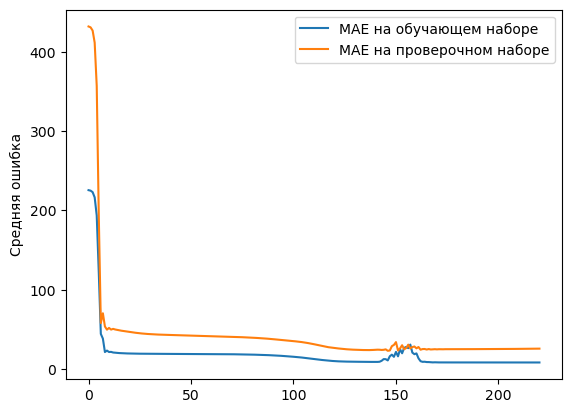

In [37]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [38]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 1ms/step


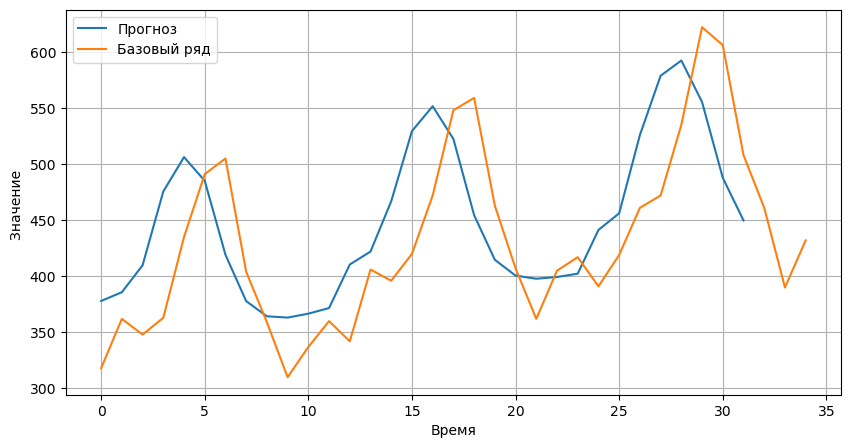

In [39]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

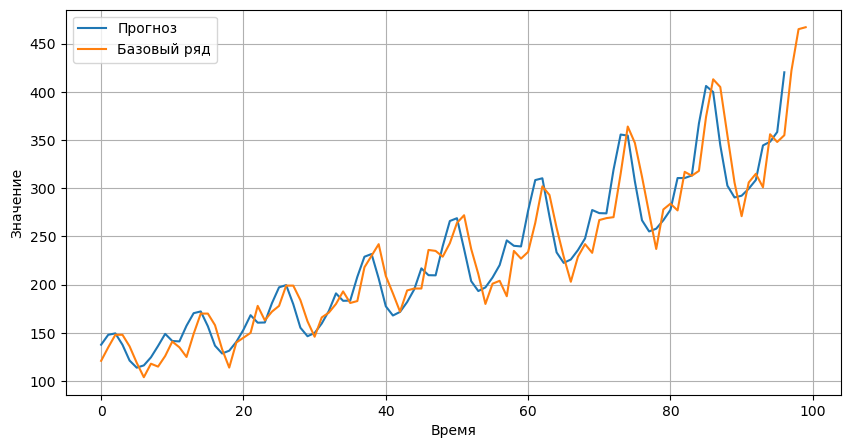

In [40]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 1ms/step - loss: 932.2661 - mae: 25.8117
train_loss: 102.20986938476562, train_m: 7.790464401245117
test_loss: 932.2660522460938, test_m: 25.81171417236328


In [53]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [54]:
results

,model,train_m,test_m
0,SimpleRNN,14.46,25.99
1,LSTM,7.79,25.81


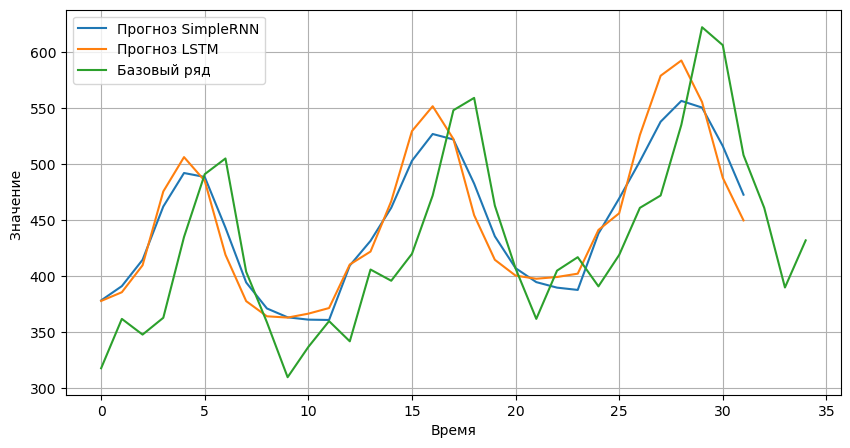

In [56]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
#plt.plot(pred_val_3[future + start: future + start + step], 
         #label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

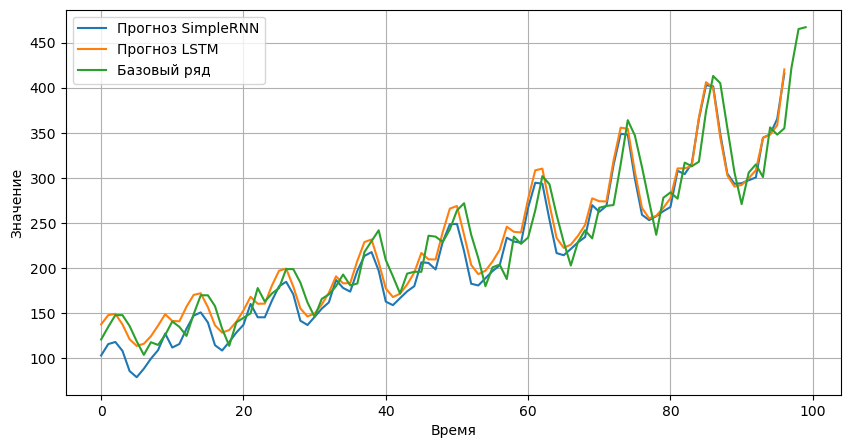

In [57]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
#plt.plot(pred_3[future + start: future + train_size], 
         #label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

#### 2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

#### Вывод: LTSM показал качество лучше, чем Simple RNN